/Users/michaelli/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation F1 Score: 0.9790794979079498


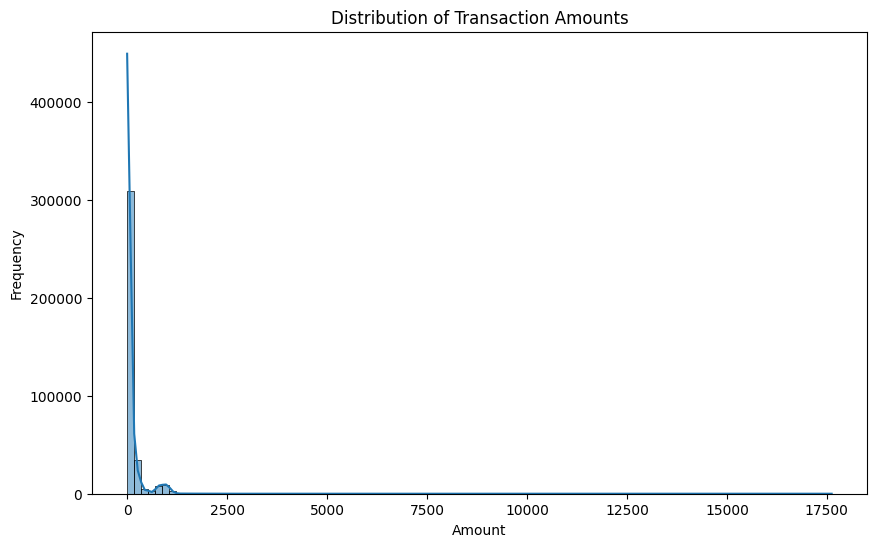

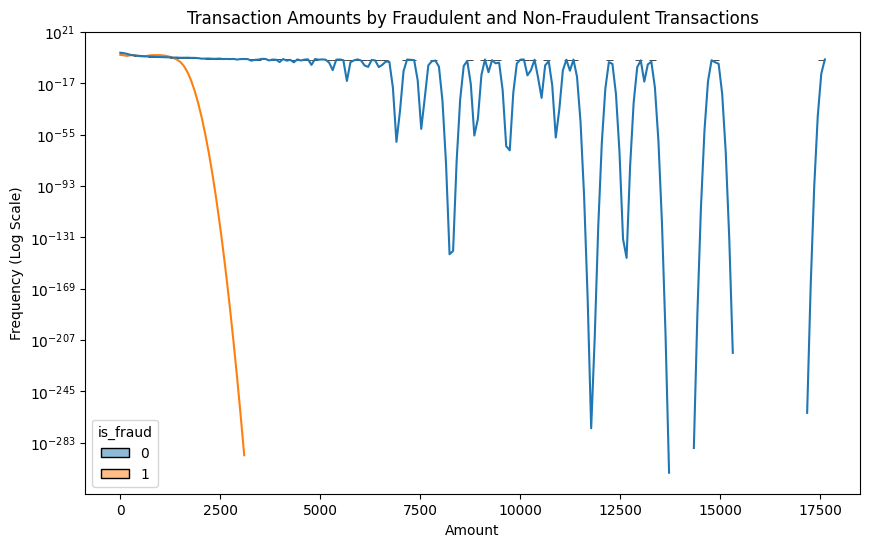

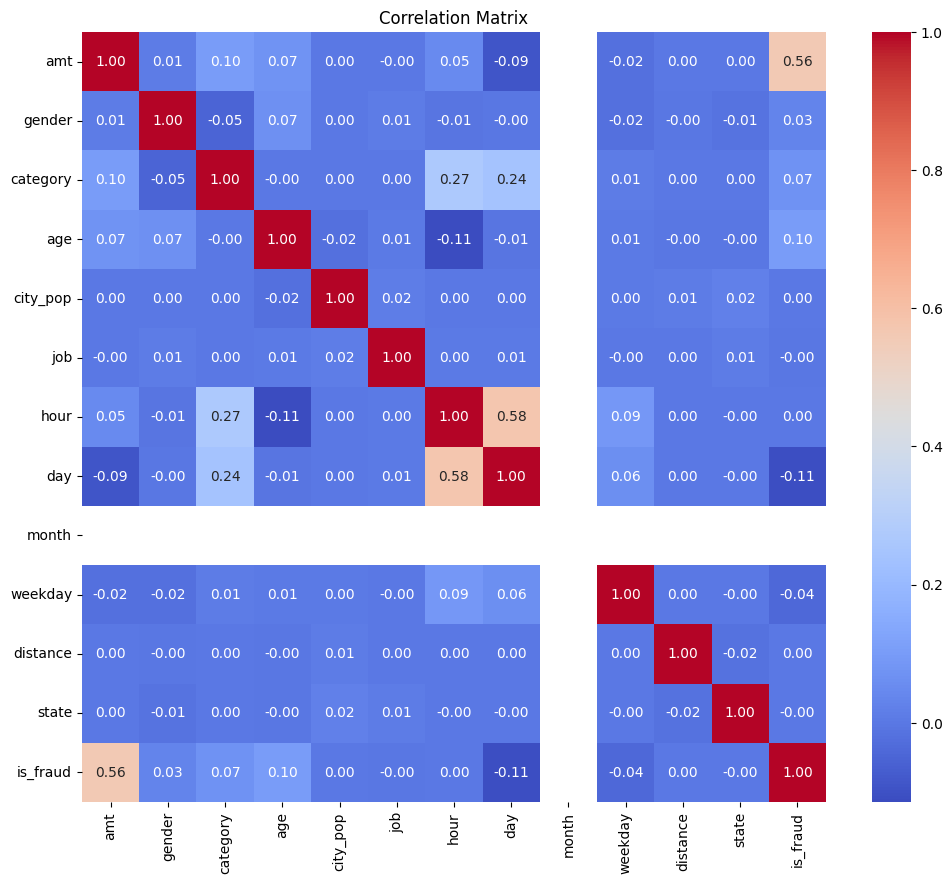

<Figure size 1000x600 with 0 Axes>

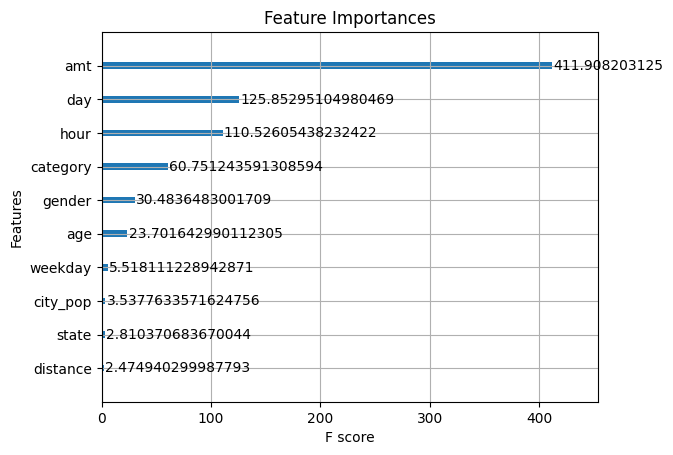

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and test datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Ensure that 'id' is not modified in 'train_df' and 'test_df'
# Do not apply any transformations to 'id'

# Feature Engineering

# Convert 'trans_date' and 'trans_time' into a single datetime column
for df in [train_df, test_df]:
    df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])

# Convert 'dob' to datetime and calculate age
for df in [train_df, test_df]:
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    df['age'] = (df['trans_datetime'] - df['dob']).dt.days / 365.25

# Extract transaction hour, day, month, and weekday
for df in [train_df, test_df]:
    df['hour'] = df['trans_datetime'].dt.hour
    df['day'] = df['trans_datetime'].dt.day
    df['month'] = df['trans_datetime'].dt.month
    df['weekday'] = df['trans_datetime'].dt.weekday

# Calculate distance between cardholder and merchant using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Earth's radius in kilometers
    return km

for df in [train_df, test_df]:
    df['distance'] = haversine_distance(df['lat'], df['long'],
                                        df['merch_lat'], df['merch_long'])

# Encode categorical variables
# Map gender to numerical values
gender_map = {'F': 0, 'M': 1}
for df in [train_df, test_df]:
    df['gender'] = df['gender'].map(gender_map)

# Label Encoding for categorical features
categorical_features = ['category', 'job', 'state']

for col in categorical_features:
    le = LabelEncoder()
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined_data)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# Select features for the model
features = [
    'amt', 'gender', 'category', 'age', 'city_pop', 'job', 'hour',
    'day', 'month', 'weekday', 'distance', 'state'
]

X = train_df[features]
y = train_df['is_fraud']
X_test = test_df[features]

# Handle missing values if any
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)
X_test = pd.DataFrame(imputer.transform(X_test), columns=features)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the XGBoost classifier
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate the model using F1-score
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
print('Validation F1 Score:', f1)

# Make predictions on the test set
test_preds = model.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'id': test_df['id'],  # Use 'id' from 'test_df' as 'id' in submission
    'is_fraud': test_preds
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


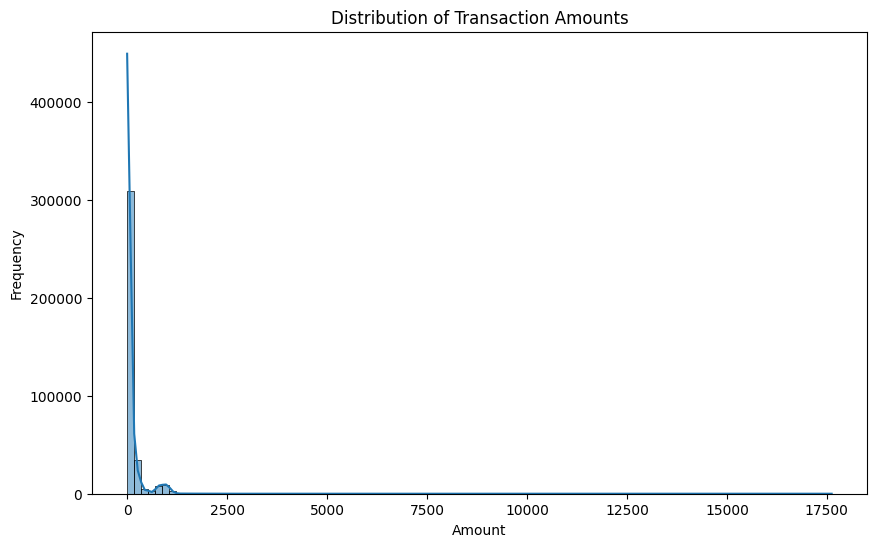

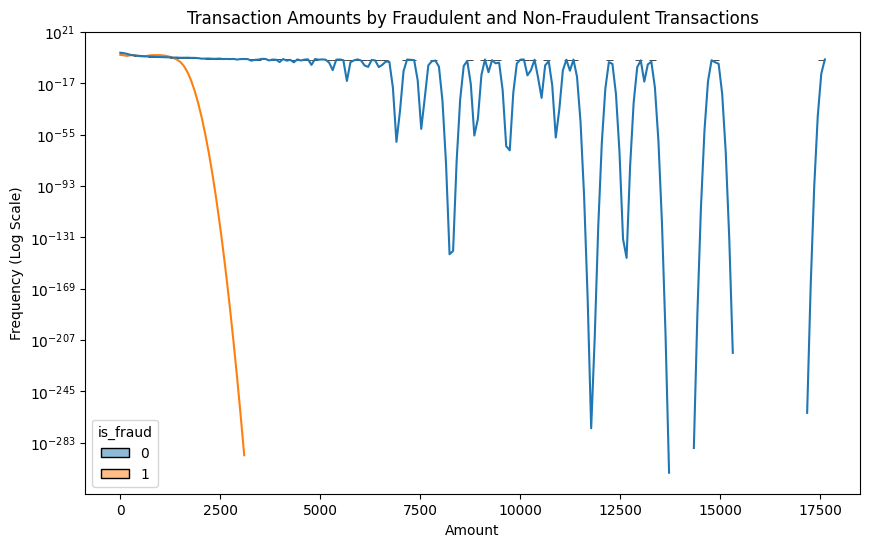

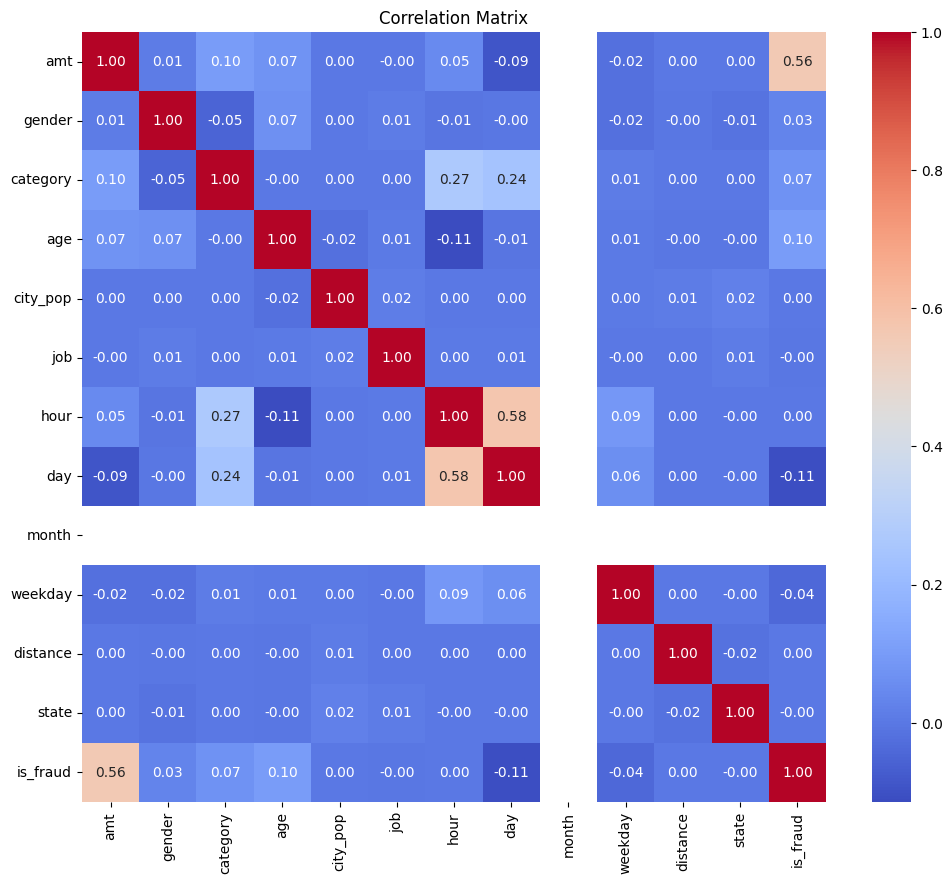

<Figure size 1000x600 with 0 Axes>

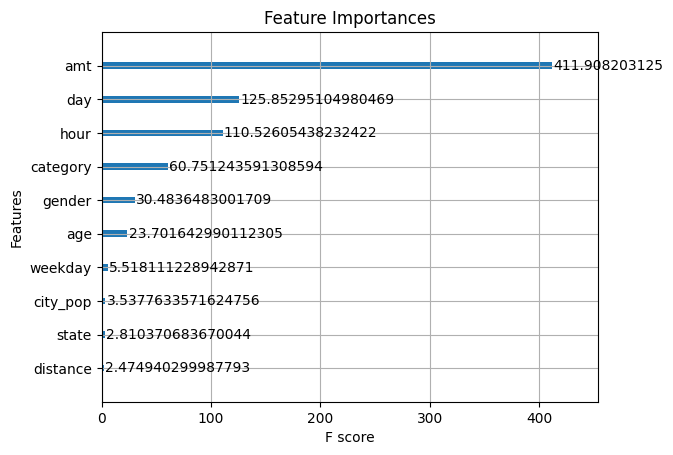

In [14]:
# Visualizations (optional)

# 1. Distribution of Transaction Amounts
plt.figure(figsize=(10,6))
sns.histplot(train_df['amt'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# 2. Transaction Amounts by Fraudulent and Non-Fraudulent Transactions
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='amt', hue='is_fraud', bins=100, kde=True, log_scale=(False, True))
plt.title('Transaction Amounts by Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency (Log Scale)')
plt.show()

# 3. Correlation Heatmap
corr_matrix = train_df[features + ['is_fraud']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 4. Feature Importances from XGBoost
plt.figure(figsize=(10,6))
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importances')
plt.show()

In [10]:
print(test_df['trans_num'].head())

0    2e6b34f2047158280fd5b50cb5249fcc
1    5e4c36e1e6f1838f0afe1ed83d42d48e
2    de58b3413be0b956c261b8e756006b5d
3    63e5e8954b6954121fb9395b8fb87ec3
4    f0acdc291ca35b61a873060e419b20a5
Name: trans_num, dtype: object


In [12]:
print(train_df.head())

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time  category     amt            cc_num    first     last  ...  \
0  1704887379         9  188.38      676355457570   Andrea  Johnson  ...   
1  1704526670         4  102.63   377178373574671   Rhonda   Chavez  ...   
2  1705632021         0    1.62  3599292013370451  Stephen     Khan  ...   
3  1705872015         5    5.64  3594292572430345   Justin   Reilly  ...   
4  1705883786         5   97.09  4867547663675548    Alice   Duarte  ...   

   merch_lat  merch_long is_fraud      trans_datetime        age  hour  day  \
0  39.268874  -89.273447        0 202